In [1]:
import pandas as pd

### Cargar Datos

In [2]:
df = pd.read_excel('Datos.xlsx')

In [3]:
df[df['ID Cliente'] == 1033]

,ID Cliente,Nodo,Inicio,Fin
1551,1033,Lista de Espera,03:14:33:19,03:14:33:19
1566,1033,Atención en Cajas,03:14:45:29,03:14:49:14


In [4]:
df.describe(include='all')

,ID Cliente,Nodo,Inicio,Fin
count,447610.00000,447610,447610,447610
unique,NaN,3,445718,445740
top,NaN,Atención en Cajas,655:18:23:36,755:15:02:30
freq,NaN,256220,3,3
mean,149565.52899,NaN,NaN,NaN
std,86410.39573,NaN,NaN,NaN
min,1.00000,NaN,NaN,NaN
25%,74673.25000,NaN,NaN,NaN
50%,149619.00000,NaN,NaN,NaN
75%,224341.75000,NaN,NaN,NaN


### Proceso de Llegada

In [5]:
df_sorted = df.sort_values(by=['ID Cliente', 'Inicio']).drop_duplicates('ID Cliente', keep='first')

In [6]:
df_sorted

,ID Cliente,Nodo,Inicio,Fin
0,1,Atención en Cajas,00:00:42:25,00:00:47:10
1,2,Atención en Cajas,00:01:00:24,00:01:27:54
2,3,Atención en Cajas,00:01:33:58,00:01:53:13
4,4,Atención en Cajas,00:02:17:32,00:02:40:20
3,5,Atención en Cajas,00:02:21:36,00:02:24:09
...,...,...,...,...
447605,299315,Atención en Cajas,999:21:45:47,999:21:49:49
447606,299316,Atención en Cajas,999:21:49:58,999:21:53:08
447607,299317,Atención en Cajas,999:21:50:42,999:22:03:21
447608,299318,Atención en Cajas,999:22:32:44,999:22:46:07


In [7]:
# Extracting the hour from 'Inicio'
df_sorted['Hour'] = df_sorted['Inicio'].str.split(':').str[1].astype(int)

# Grouping by 'Hour' and counting the number of arrivals
arrivals_per_hour = df_sorted.groupby('Hour').size()/1000

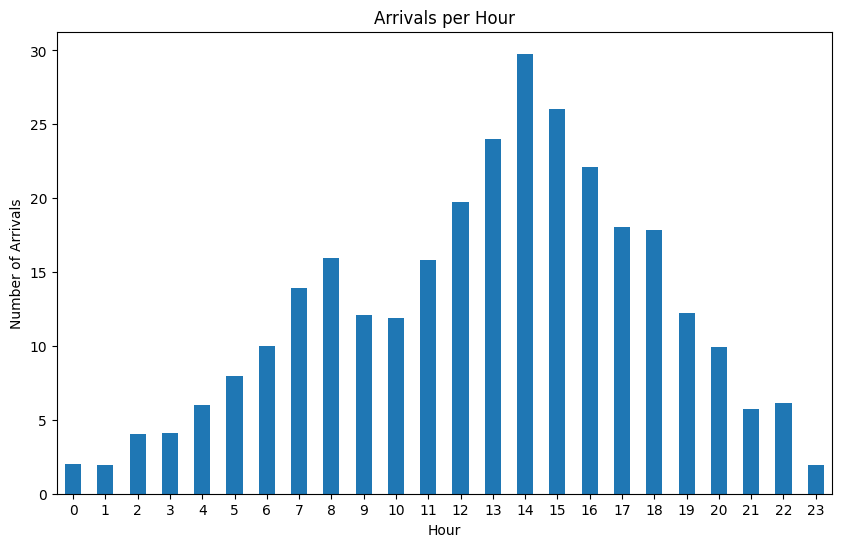

In [8]:
import matplotlib.pyplot as plt

# Plotting the arrivals per hour
arrivals_per_hour.plot(kind='bar', figsize=(10, 6))
plt.title('Arrivals per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Arrivals')
plt.xticks(rotation=0)
plt.show()

In [9]:
arrivals_per_hour

Hour
0      1.979
1      1.972
2      4.054
3      4.088
4      5.998
5      7.970
6     10.015
7     13.922
8     15.979
9     12.109
10    11.913
11    15.789
12    19.744
13    24.030
14    29.776
15    26.026
16    22.102
17    18.033
18    17.814
19    12.224
20     9.957
21     5.730
22     6.152
23     1.943
dtype: float64

In [10]:
import numpy as np

def lambda_t(t):
    # Definimos los rangos de acuerdo con la tabla proporcionada
    tabla = [
        (0, 1, 1.979),
        (1, 2, 1.972),
        (2, 3, 4.054),
        (3, 4, 4.088),
        (4, 5, 5.998),
        (5, 6, 7.970),
        (6, 7, 10.015),
        (7, 8, 13.922),
        (8, 9, 15.979),
        (9, 10, 12.109),
        (10, 11, 11.913),
        (11, 12, 15.789),
        (12, 13, 19.744),
        (13, 14, 24.030),
        (14, 15, 29.776),
        (15, 16, 26.026),
        (16, 17, 22.102),
        (17, 18, 18.033),
        (18, 19, 17.814),
        (19, 20, 12.224),
        (20, 21, 9.957),
        (21, 22, 5.730),
        (22, 23, 6.152),
        (23, 24, 1.943)
    ]
    
    # Iteramos sobre la tabla para encontrar el rango correspondiente
    for valor_min, valor_max, lambda_valor in tabla:
        if valor_min <= t < valor_max:
            return lambda_valor
    
    # Si el valor no está en ningún rango, devolver None o un mensaje de error
    return None

def obtener_mayor_tasa(lambda_t):
    # Suponemos que t varía entre 0 y 24, basado en los valores de la tabla
    max_tasa = max(lambda_t(t) for t in range(24))
    return max_tasa

def generar_poisson_no_homogeneo(lambda_t, T_max):
    t = 0
    lambda_u = obtener_mayor_tasa(lambda_t)
    eventos = list()
    while True:
        # Paso 1: Generar u1 ~ U(0,1)
        u1 = np.random.uniform(0, 1)
        
        # Paso 2: Actualizar t
        t -= (1 / lambda_u) * np.log(u1)
        
        # Paso 3: Generar u2 ~ U(0,1)
        u2 = np.random.uniform(0, 1)
        
        # Paso 4: Comparar u2 con λ(t)/λ_u
        if u2 <= lambda_t(t%24) / lambda_u:
            eventos.append(t)
            if t > T_max:
                return np.array(eventos)

In [11]:
test = generar_poisson_no_homogeneo(lambda_t, 24*1000)%24

# Contar el número de eventos en cada intervalo de 1 hora
hist, _ = np.histogram(test, bins=24)

# Calcular la tasa de ocurrencia promedio por cada intervalo de 1 hora
tasa_ocurrencia_promedio_por_intervalo = hist/1000

# Devolver el resultado
tasa_ocurrencia_promedio_por_intervalo

array([ 1.996,  1.933,  4.121,  4.176,  5.955,  8.098, 10.018, 13.875,
       15.798, 11.856, 11.891, 15.867, 19.759, 24.21 , 29.937, 25.977,
       21.992, 18.061, 17.761, 12.135,  9.984,  5.527,  6.127,  1.957])

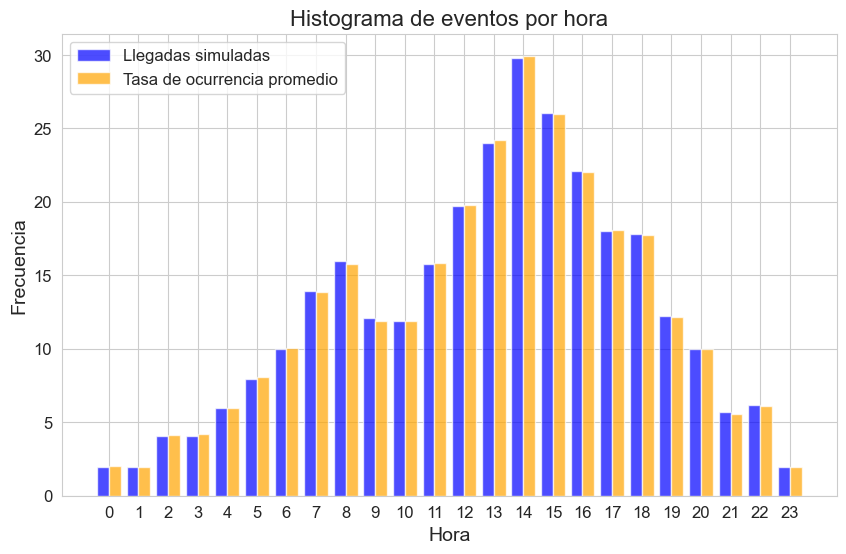

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Ancho de las barras
bar_width = 0.4

# Posiciones para las barras
r1 = np.arange(24)
r2 = [x + bar_width for x in r1]

# Crear la figura y las barras
plt.figure(figsize=(10, 6))
plt.bar(r1, arrivals_per_hour, color='blue', width=bar_width, alpha=0.7, label='Llegadas simuladas')
plt.bar(r2, tasa_ocurrencia_promedio_por_intervalo, color='orange', width=bar_width, alpha=0.7, label='Tasa de ocurrencia promedio')

# Títulos y etiquetas
plt.title('Histograma de eventos por hora', fontsize=16)
plt.xlabel('Hora', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks([r + bar_width / 2 for r in range(24)], range(24), fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la cuadrícula
plt.grid(True)

# Añadir leyenda
plt.legend(loc='upper left', fontsize=12)

# Mostrar el gráfico
plt.show()

### Tiempo de Servicio

In [13]:
df_servicio = df[df['Nodo'] == 'Atención en Cajas']

In [14]:
# Convertir las columnas 'Inicio' y 'Fin' a formato de tiempo compatible
def convert_to_timedelta(time_str):
    d, h, m, s = map(int, time_str.split(':'))
    return pd.Timedelta(days=d, hours=h, minutes=m, seconds=s)

df_servicio['Inicio'] = df_servicio['Inicio'].apply(convert_to_timedelta)
df_servicio['Fin'] = df_servicio['Fin'].apply(convert_to_timedelta)

df_servicio['Tiempo Servicio'] = df_servicio['Fin'] - df_servicio['Inicio']

# Convertir la duración a horas
df_servicio['Duración en Horas'] = df_servicio['Tiempo Servicio'].dt.total_seconds() / 3600

C:\Users\Matías\AppData\Local\Temp\ipykernel_28552\1901632215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_servicio['Inicio'] = df_servicio['Inicio'].apply(convert_to_timedelta)
C:\Users\Matías\AppData\Local\Temp\ipykernel_28552\1901632215.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_servicio['Fin'] = df_servicio['Fin'].apply(convert_to_timedelta)
C:\Users\Matías\AppData\Local\Temp\ipykernel_28552\1901632215.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

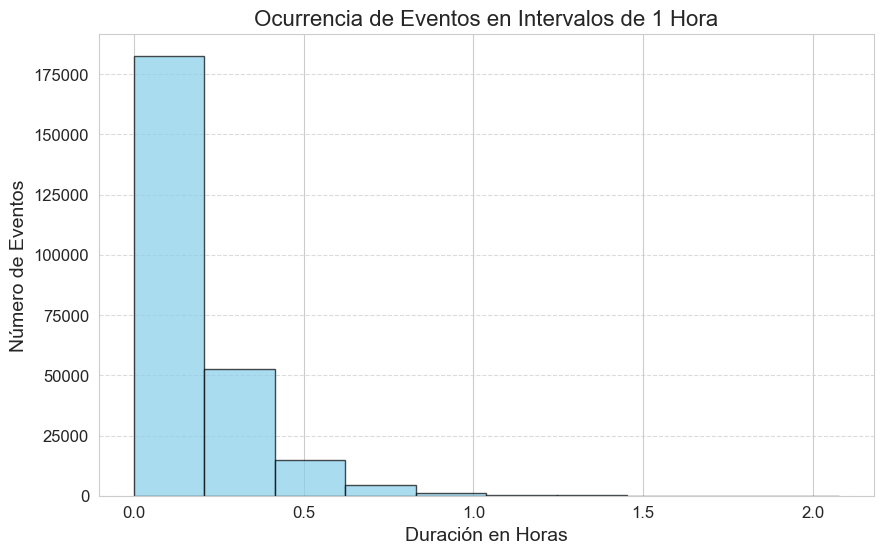

In [15]:
# Crear el histograma con intervalos de 1 hora
plt.figure(figsize=(10, 6))
plt.hist(df_servicio['Duración en Horas'], edgecolor='black', color='skyblue', alpha=0.7)

# Títulos y etiquetas
plt.title("Ocurrencia de Eventos en Intervalos de 1 Hora", fontsize=16)
plt.xlabel("Duración en Horas", fontsize=14)
plt.ylabel("Número de Eventos", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la cuadrícula solo en el eje y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.009891,893.354832,914.262416,inf,0.001832,3.557415e-01
gamma,0.021165,887.940386,919.301761,inf,0.003348,6.397940e-03
lognorm,4.280536,618.366024,649.727400,inf,0.036412,1.370000e-295
beta,8.211116,1472.039404,1513.854571,inf,0.062972,0.000000e+00
norm,43.880112,3877.521790,3898.429374,inf,0.158532,0.000000e+00


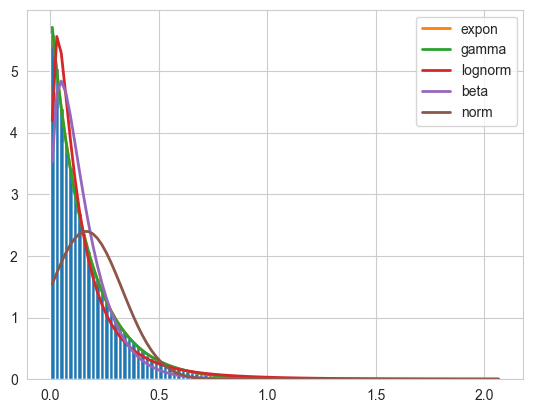

In [18]:
from fitter import Fitter

# Usar Fitter para ajustar la columna 'Duración en Horas' y detectar la mejor distribución
f = Fitter(df_servicio['Duración en Horas'], distributions=['gamma', 'lognorm', 'beta', 'norm', 'expon'])
f.fit()

# Mostrar las mejores distribuciones encontradas
f.summary()

In [19]:
# Obtener la mejor distribución y sus parámetros
best_distribution = f.get_best()
best_distribution_name = list(best_distribution.keys())[0]
best_distribution_params = best_distribution[best_distribution_name]

print(f"La mejor distribución es: {best_distribution_name}")
print(f"Parámetros de la mejor distribución: {best_distribution_params}")

La mejor distribución es: expon
Parámetros de la mejor distribución: {'loc': 0.0, 'scale': 0.1663156965801959}


In [20]:
def generar_servicios(llegadas, tasa=0.1663156965801959):
    return np.random.exponential(tasa, len(llegadas))

def generar_incertidumbre(lambda_t, T_max):
    llegadas = generar_poisson_no_homogeneo(lambda_t, T_max)
    return list(llegadas), list(generar_servicios(llegadas))

### Estadígrafos para Validar

In [21]:
df = pd.read_excel('Datos.xlsx')

In [22]:
# Filtrar clientes con Nodo 'Rechazo'
clientes_rechazo = df[df['Nodo'] == 'Rechazo']

# Calcular el porcentaje
porcentaje_rechazo = (len(clientes_rechazo) / df['ID Cliente'].max()) * 100

print(f"Porcentaje de clientes con Nodo 'Rechazo': {porcentaje_rechazo:.4f}%")

Porcentaje de clientes con Nodo 'Rechazo': 14.3990%


In [23]:
# Filtrar clientes con Nodo 'Lista de Espera'
clientes_lista_espera = df[df['Nodo'] == 'Lista de Espera']

# Calcular el porcentaje
porcentaje_lista_espera = (len(clientes_lista_espera) / df['ID Cliente'].max()) * 100

print(f"Porcentaje de clientes con Nodo 'Lista de Espera': {porcentaje_lista_espera:.4f}%")

Porcentaje de clientes con Nodo 'Lista de Espera': 49.5428%


In [24]:
df['Inicio'] = df['Inicio'].apply(convert_to_timedelta)
df['Fin'] = df['Fin'].apply(convert_to_timedelta)

# Filtrar filas con 'Lista de Espera' y 'Atención en Cajas'
lista_espera = df[df['Nodo'] == 'Lista de Espera'].set_index('ID Cliente')
atencion_cajas = df[df['Nodo'] == 'Atención en Cajas'].set_index('ID Cliente')

# Unir ambos DataFrames por 'ID Cliente'
merged = lista_espera[['Fin']].join(atencion_cajas[['Inicio']], lsuffix='_ListaEspera', rsuffix='_AtencionCajas')

# Calcular la diferencia
merged['Diferencia'] = merged['Inicio'] - merged['Fin']

In [25]:
merged['Diferencia'].mean()

Timedelta('0 days 00:10:13.763721331')